# Multi-Objective Bayesian Optimization for K-Nearest Neighbors Mass Spectrometry Model

This notebook implements multi-objective Bayesian optimization using Ax and BoTorch for hyperparameter tuning of a KNN model for mass spectrometry prediction.

## Mathematical Framework

### Multi-Objective Optimization Problem

We solve the multi-objective optimization problem:

$$\mathbf{x}^* = \arg\max_{\mathbf{x} \in \mathcal{X}} [f_1(\mathbf{x}), -f_2(\mathbf{x})]$$

Where:
- $f_1(\mathbf{x})$ = Cosine similarity (maximize)
- $f_2(\mathbf{x})$ = RMSE (minimize, hence negated)
- $\mathcal{X}$ = Hyperparameter search space

### Gaussian Process Surrogate Model

Each objective is modeled with a Gaussian Process:

$$f_i(\mathbf{x}) \sim \mathcal{GP}(\mu_i(\mathbf{x}), k_i(\mathbf{x}, \mathbf{x}'))$$

### Batch Acquisition Function

We use qNEHVI (quasi-Noisy Expected Hypervolume Improvement) for batch acquisition:

$$\alpha_{qNEHVI}(\mathbf{X}) = \mathbb{E}[HV(\mathcal{P} \cup f(\mathbf{X})) - HV(\mathcal{P})]$$

Where $\mathcal{P}$ is the current Pareto frontier and $HV$ is the hypervolume indicator.

## 1. Environment Setup and Thread Control

Set environment variables before importing numerical libraries to prevent thread oversubscription.

In [1]:
# Prevent thread oversubscription for parallel processing
import os
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")

import json
import pickle
import warnings
import logging
from typing import Dict, Any, Tuple, List, Optional, Union
from datetime import datetime
from dataclasses import dataclass, field
from pathlib import Path
import time

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, spearmanr
from joblib import Parallel, delayed

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Force CPU usage for torch (MPS doesn't work with BoTorch)
torch.set_default_device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(-1)  # Disable CUDA
    
# Ax and BoTorch imports
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Generators
from ax.core.optimization_config import MultiObjectiveOptimizationConfig
from ax.core.objective import MultiObjective, Objective
from ax.core.metric import Metric
from ax.core.outcome_constraint import ObjectiveThreshold
from ax.core.types import ComparisonOp

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

logger.info(f"Environment setup complete. CPU count: {os.cpu_count()}")
logger.info(f"Torch device: {torch.get_default_device() if hasattr(torch, 'get_default_device') else 'cpu'}")
logger.info("BoTorch will run on CPU (required for stability)")

[WARNING 08-25 16:48:16] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.
/var/folders/_g/yv_ycc0s11z1x8zk__56l6r80000gn/T/ipykernel_34430/2782887333.py:42: DeprecationWarning: Please import from 'ax.generation_strategy.generation_strategy' instead of 'ax.modelbridge.generation_strategy'. The latter is deprecated and will be removed in a future release.
  from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
2025-08-25 16:48:16,647 - INFO - Environment setup complete. CPU count: 16
2025-08-25 16:48:16,648 - INFO - Torch device: cpu
2025-08-25 16:48:16,648 - INFO - BoTorch will run on CPU (required for stability)


## 2. Configuration Dataclass

Using dataclasses for clean configuration management following SOLID principles.

In [2]:
@dataclass
class OptimizationConfig:
    """Configuration for Bayesian optimization."""
    # Data paths
    results_dir: Path = Path('../data/results')
    models_dir: Path = Path('../models/knn_bayesian_optimized')
    input_type: str = 'hpj'
    use_selected_data: bool = False
    
    # Data processing
    transform_sqrt: bool = True
    validation_split: float = 0.2
    random_state: int = 42
    
    # Optimization settings
    n_iterations: int = 50
    n_initial_points: int = 14  # Sobol initialization
    batch_size: int = 12  # Parallel evaluations
    
    # Speed optimization
    row_subsample_frac: float = 1  # Subsample for faster evaluation
    max_bins_eval: int = 512  # Limit bins for evaluation
    
    # Multi-objective settings
    objectives: List[str] = field(default_factory=lambda: ['cosine_similarity', 'rmse'])
    minimize: List[bool] = field(default_factory=lambda: [False, True])
    
    def __post_init__(self):
        self.models_dir.mkdir(parents=True, exist_ok=True)
        
    @property
    def data_dir(self) -> Path:
        subdir = 'selected' if self.use_selected_data else 'full_featurised'
        return self.results_dir / self.input_type / subdir
    
    def get_data_paths(self) -> Dict[str, Path]:
        return {
            'train': self.data_dir / 'train_data.jsonl',
            'val': self.data_dir / 'val_data.jsonl',
            'test': self.data_dir / 'test_data.jsonl'
        }

config = OptimizationConfig()

## 3. Data Loading and Preprocessing

Efficient data loading with vectorized operations and proper scaler management.

In [3]:
class DataLoader:
    """Handles data loading and preprocessing."""
    
    @staticmethod
    def load_jsonl(filepath: Path) -> Tuple[List[str], np.ndarray, np.ndarray]:
        """Load data from JSONL file."""
        if not filepath.exists():
            raise FileNotFoundError(f"File not found: {filepath}")
        
        data = []
        with open(filepath, 'r') as f:
            for line in tqdm(f, desc=f"Loading {filepath.name}"):
                try:
                    record = json.loads(line)
                    if all(k in record for k in ['smiles', 'features', 'target']):
                        data.append(record)
                except json.JSONDecodeError:
                    continue
        
        if not data:
            raise ValueError(f"No valid data in {filepath}")
        
        smiles = [d['smiles'] for d in data]
        features = np.array([d['features'] for d in data])
        targets = np.array([d['target'] for d in data])
        
        logger.info(f"Loaded {len(smiles)} samples from {filepath.name}")
        return smiles, features, targets
    
    @staticmethod
    def prepare_data(config: OptimizationConfig) -> Dict[str, Any]:
        """Load and prepare all data using existing train/val/test splits."""
        paths = config.get_data_paths()
        
        # Load all three splits
        train_smiles, X_train, y_train = DataLoader.load_jsonl(paths['train'])
        val_smiles, X_val, y_val = DataLoader.load_jsonl(paths['val'])
        test_smiles, X_test, y_test = DataLoader.load_jsonl(paths['test'])
        
        # Apply transformation
        if config.transform_sqrt:
            y_train = np.sqrt(np.maximum(y_train, 0))
            y_val = np.sqrt(np.maximum(y_val, 0))
            y_test = np.sqrt(np.maximum(y_test, 0))
        
        # Create subsampled indices for fast evaluation during optimization
        rng = np.random.RandomState(config.random_state)
        n_subsample = int(len(X_val) * config.row_subsample_frac)
        row_idx = rng.choice(len(X_val), n_subsample, replace=False)
        bin_idx = slice(None, min(config.max_bins_eval, y_val.shape[1]))
        
        # Scale features for optimization - fit on train, apply to val
        opt_scaler = StandardScaler()
        X_train_scaled = opt_scaler.fit_transform(X_train)
        X_val_scaled = opt_scaler.transform(X_val)
        
        # Subsampled validation data for fast evaluation
        X_val_sub = X_val_scaled[row_idx]
        y_val_sub = y_val[row_idx][:, bin_idx]
        
        # Separate scaler for final training (refit on full train for final model)
        final_scaler = StandardScaler()
        X_train_final = final_scaler.fit_transform(X_train)
        X_test_scaled = final_scaler.transform(X_test)
        
        return {
            'X_opt_train': X_train_scaled,  # For optimization
            'X_opt_val': X_val_scaled,      # Full validation
            'y_opt_train': y_train,
            'y_opt_val': y_val,
            'X_opt_val_sub': X_val_sub,     # Subsampled validation
            'y_opt_val_sub': y_val_sub,
            'X_train': X_train_final,       # For final training
            'X_test': X_test_scaled,        # For final evaluation
            'y_train': y_train,
            'y_val': y_val,                 # Keep original val
            'y_test': y_test,
            'opt_scaler': opt_scaler,
            'final_scaler': final_scaler,
            'bin_idx': bin_idx
        }

# Load data
data = DataLoader.prepare_data(config)
logger.info(f"Data shapes - Train: {data['X_opt_train'].shape}, Val: {data['X_opt_val'].shape}, Test: {data['X_test'].shape}")
logger.info(f"Subsampled val for fast eval: {data['X_opt_val_sub'].shape}")

Loading train_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:48:18,271 - INFO - Loaded 2176 samples from train_data.jsonl


Loading val_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:48:18,528 - INFO - Loaded 272 samples from val_data.jsonl


Loading test_data.jsonl: 0it [00:00, ?it/s]

2025-08-25 16:48:18,730 - INFO - Loaded 272 samples from test_data.jsonl
2025-08-25 16:48:18,901 - INFO - Data shapes - Train: (2176, 7137), Val: (272, 7137), Test: (272, 7137)
2025-08-25 16:48:18,902 - INFO - Subsampled val for fast eval: (272, 7137)


## 4. Metrics Computation

Vectorized metrics computation for efficiency.

In [4]:
class MetricsComputer:
    """Compute evaluation metrics."""
    
    @staticmethod
    def cosine_similarity(y_true: np.ndarray, y_pred: np.ndarray) -> float:
        """Compute mean cosine similarity."""
        # Vectorized cosine similarity
        dot_product = np.sum(y_true * y_pred, axis=1)
        norm_true = np.linalg.norm(y_true, axis=1)
        norm_pred = np.linalg.norm(y_pred, axis=1)
        
        # Avoid division by zero
        valid_mask = (norm_true > 0) & (norm_pred > 0)
        similarities = np.zeros(len(y_true))
        similarities[valid_mask] = dot_product[valid_mask] / (norm_true[valid_mask] * norm_pred[valid_mask])
        
        return float(np.mean(similarities))
    
    @staticmethod
    def compute_all_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
        """Compute all evaluation metrics."""
        return {
            'cosine_similarity': MetricsComputer.cosine_similarity(y_true, y_pred),
            'rmse': float(np.sqrt(mean_squared_error(y_true, y_pred))),
            'mae': float(mean_absolute_error(y_true, y_pred)),
            'r2': float(r2_score(y_true, y_pred))
        }

## 5. Search Space Definition

Define the hyperparameter search space for KNN.

### Search Space Design

We define a comprehensive search space $\mathcal{X}$ covering:

- **Number of neighbors**: $k \in [1, 100]$
- **Weights**: $w \in \{\text{uniform}, \text{distance}\}$
- **Algorithm**: $a \in \{\text{auto}, \text{ball_tree}, \text{kd_tree}, \text{brute}\}$
- **Metric**: $m \in \{\text{euclidean}, \text{manhattan}, \text{minkowski}, \text{chebyshev}\}$
- **Power parameter**: $p \in [1, 5]$ for Minkowski distance
- **Leaf size**: $l \in [10, 100]$ for tree algorithms

In [5]:
def create_search_space() -> List[Dict[str, Any]]:
    """Create Ax search space for KNN."""
    return [
        {
            "name": "n_neighbors",
            "type": "range",
            "bounds": [1, 100],
            "value_type": "int",
            "log_scale": False
        },
        {
            "name": "weights",
            "type": "choice",
            "values": ["uniform", "distance"],
            "value_type": "str"
        },
        {
            "name": "algorithm",
            "type": "choice",
            "values": ["auto", "ball_tree", "kd_tree", "brute"],
            "value_type": "str"
        },
        {
            "name": "metric",
            "type": "choice",
            "values": ["euclidean", "manhattan", "minkowski", "chebyshev"],
            "value_type": "str"
        },
        {
            "name": "p",
            "type": "range",
            "bounds": [1, 5],
            "value_type": "int",
            "log_scale": False
        },
        {
            "name": "leaf_size",
            "type": "range",
            "bounds": [10, 100],
            "value_type": "int",
            "log_scale": False
        }
    ]

## 6. Evaluation Function

The evaluation function trains a KNN model and returns multiple objectives.
Uses subsampled data for faster evaluation during optimization.

In [6]:
def evaluate_parameters(parameters: Dict[str, Any], data: Dict[str, np.ndarray], 
                        use_subsample: bool = True) -> Dict[str, Tuple[float, float]]:
    """Evaluate KNN with given parameters.
    
    Args:
        parameters: Hyperparameters to evaluate
        data: Data dictionary
        use_subsample: Whether to use subsampled data for faster evaluation
    
    Returns:
        dict with cosine_similarity and rmse (mean, sem) tuples
    """
    # Handle metric compatibility
    metric = parameters['metric']
    algorithm = parameters['algorithm']
    p = parameters['p']
    
    # KD-tree only supports limited metrics
    if algorithm == 'kd_tree' and metric not in ['euclidean', 'minkowski', 'chebyshev']:
        algorithm = 'ball_tree'
    
    # Create KNN parameters
    knn_params = {
        'n_neighbors': parameters['n_neighbors'],
        'weights': parameters['weights'],
        'algorithm': algorithm,
        'leaf_size': parameters['leaf_size'],
        'metric': metric,
        'n_jobs': 1  # Avoid nested parallelism
    }
    
    # Add p parameter only for minkowski
    if metric == 'minkowski':
        knn_params['p'] = p
    
    # Create model
    knn = KNeighborsRegressor(**knn_params)
    
    # Select appropriate data
    if use_subsample:
        # Train on subsampled bins for speed
        y_train_sub = data['y_opt_train'][:, data['bin_idx']]
        knn.fit(data['X_opt_train'], y_train_sub)
        
        # Predict on subsampled validation
        y_pred = knn.predict(data['X_opt_val_sub'])
        y_true = data['y_opt_val_sub']
    else:
        # Full data evaluation
        knn.fit(data['X_opt_train'], data['y_opt_train'])
        y_pred = knn.predict(data['X_opt_val'])
        y_true = data['y_opt_val']
    
    y_pred = np.maximum(y_pred, 0)  # Ensure non-negative
    
    # Compute metrics
    metrics = MetricsComputer.compute_all_metrics(y_true, y_pred)
    
    return {
        'cosine_similarity': (metrics['cosine_similarity'], 0.0),  # (mean, sem)
        'rmse': (metrics['rmse'], 0.0)
    }

# Helper function for parallel evaluation (no AxClient calls)
def _run_eval(params: Dict[str, Any]) -> Dict[str, Tuple[float, float]]:
    """Wrapper for parallel evaluation - compute only, no AxClient calls."""
    return evaluate_parameters(params, data, use_subsample=True)

## 7. Multi-Objective Bayesian Optimization Setup

### Optimization Strategy

1. **Initialization Phase**: Use Sobol sequence for space-filling design
2. **Threshold Setting**: After initialization, set objective thresholds based on observed data
3. **Bayesian Phase**: Use NEHVI for multi-objective acquisition with proper reference points
4. **Parallel Batch Evaluation**: Evaluate multiple candidates in parallel using joblib

The Pareto frontier $\mathcal{P}$ is updated after each batch:

$$\mathcal{P}_{t+1} = \text{ParetoFrontier}(\mathcal{P}_t \cup \{f(\mathbf{x}_i)\}_{i=1}^{b})$$

In [7]:
# Initialize Ax client
ax_client = AxClient(verbose_logging=False)

# Create experiment with multi-objective optimization
# Set immutable_search_space_and_opt_config=False to allow threshold updates
ax_client.create_experiment(
    name="knn_multi_objective_optimization",
    parameters=create_search_space(),
    objectives={
        "cosine_similarity": ObjectiveProperties(minimize=False),
        "rmse": ObjectiveProperties(minimize=True)
    },
    overwrite_existing_experiment=True,
    immutable_search_space_and_opt_config=False,  # Allow config updates
)

# Define generation strategy for efficient optimization
gs = GenerationStrategy(
    steps=[
        # Sobol initialization for space exploration
        GenerationStep(
            model=Generators.SOBOL,
            num_trials=config.n_initial_points,
            min_trials_observed=config.n_initial_points
        ),
        # Multi-objective Bayesian optimization
        GenerationStep(
            model=Generators.BOTORCH_MODULAR,
            num_trials=-1,  # No limit
        )
    ]
)

ax_client._generation_strategy = gs

logger.info("Starting multi-objective Bayesian optimization for KNN")
logger.info(f"Objectives: maximize cosine_similarity, minimize RMSE")
logger.info(f"Total trials: {config.n_iterations}, Batch size: {config.batch_size}")
logger.info(f"Parallel workers: {min(config.batch_size, os.cpu_count())}")

[WARNING 08-25 16:48:19] ax.service.utils.instantiation: Objective thresholds were not set. They will be selected using a heuristic, but should be specified on the objective for best performance.
[INFO 08-25 16:48:19] ax.generation_strategy.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+BO_MIXED', steps=[Sobol for 12 trials, BO_MIXED for subsequent trials]). Iterations after 12 will take longer to generate due to model-fitting.
2025-08-25 16:48:19,026 - INFO - Starting multi-objective Bayesian optimization for KNN
2025-08-25 16:48:19,027 - INFO - Objectives: maximize cosine_similarity, minimize RMSE
2025-08-25 16:48:19,027 - INFO - Total trials: 50, Batch size: 12
2025-08-25 16:48:19,027 - INFO - Parallel workers: 12


## 8. Optimization Loop - Phase 1: Sobol Initialization

Run Sobol initialization with parallel batch evaluation to explore the space.

In [8]:
# Storage for results
trials_data = []
best_cosine = -np.inf
best_rmse = np.inf

# Start optimization timer
optimization_start_time = time.time()

# Progress bar
pbar = tqdm(total=config.n_iterations, desc="Optimization Progress")

# Phase 1: Sobol initialization with parallel evaluation
logger.info("Phase 1: Sobol initialization with parallel evaluation")
trial_index = 0

while trial_index < config.n_initial_points:
    # Generate batch of trials
    batch_size = min(config.batch_size, config.n_initial_points - trial_index)
    
    batch_trials = []
    for _ in range(batch_size):
        parameters, trial_id = ax_client.get_next_trial()
        batch_trials.append((parameters, trial_id))
    
    # Extract parameters for parallel evaluation
    params_list = [params for params, _ in batch_trials]
    
    # Run evaluations in parallel
    raw_list = Parallel(
        n_jobs=min(config.batch_size, os.cpu_count()),
        backend="loky",  # Good for macOS/Jupyter
        prefer="processes"
    )(delayed(_run_eval)(p) for p in params_list)
    
    # Log results back to Ax sequentially (AxClient isn't process-safe)
    for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
        try:
            # Complete trial
            ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
            
            # Extract metrics
            cosine_sim = raw_data['cosine_similarity'][0]
            rmse = raw_data['rmse'][0]
            
            # Track results
            trial_data = {
                'trial_id': trial_id,
                'parameters': parameters,
                'cosine_similarity': cosine_sim,
                'rmse': rmse,
                'phase': 'sobol'
            }
            trials_data.append(trial_data)
            
            # Update best values
            if cosine_sim > best_cosine:
                best_cosine = cosine_sim
            if rmse < best_rmse:
                best_rmse = rmse
            
            # Update progress
            pbar.set_postfix({
                'Phase': 'Sobol',
                'Best Cosine': f'{best_cosine:.4f}',
                'Best RMSE': f'{best_rmse:.4f}'
            })
            
        except Exception as e:
            logger.error(f"Trial {trial_id} failed: {e}")
            ax_client.log_trial_failure(trial_index=trial_id)
    
    trial_index += batch_size
    pbar.update(batch_size)

logger.info(f"Sobol initialization complete. Setting objective thresholds...")

Optimization Progress:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-25 16:48:19,053 - INFO - Phase 1: Sobol initialization with parallel evaluation
2025-08-25 16:48:50,107 - INFO - Sobol initialization complete. Setting objective thresholds...


## 9. Set Objective Thresholds

Set objective thresholds based on observed data from Sobol initialization.
This provides NEHVI with proper reference points for hypervolume computation.

In [9]:
# Compute thresholds from observed data
df_sobol = pd.DataFrame(trials_data)
cos_threshold = float(np.percentile(df_sobol["cosine_similarity"], 10))  # Lower bound (maximize)
rmse_threshold = float(np.percentile(df_sobol["rmse"], 90))             # Upper bound (minimize)

logger.info(f"Setting thresholds - Cosine >= {cos_threshold:.4f}, RMSE <= {rmse_threshold:.4f}")

# Create metrics
cosine_metric = Metric(name="cosine_similarity")
rmse_metric = Metric(name="rmse")

# Update optimization config with thresholds
ax_client.experiment.optimization_config = MultiObjectiveOptimizationConfig(
    objective=MultiObjective(
        objectives=[
            Objective(metric=cosine_metric, minimize=False),
            Objective(metric=rmse_metric, minimize=True),
        ]
    ),
    objective_thresholds=[
        ObjectiveThreshold(
            metric=cosine_metric,
            bound=cos_threshold,
            op=ComparisonOp.GEQ,
            relative=False
        ),
        ObjectiveThreshold(
            metric=rmse_metric,
            bound=rmse_threshold,
            op=ComparisonOp.LEQ,
            relative=False
        ),
    ],
)

2025-08-25 16:48:50,130 - INFO - Setting thresholds - Cosine >= 0.5597, RMSE <= 0.1003


## 10. Optimization Loop - Phase 2: Bayesian Optimization

Continue with multi-objective Bayesian optimization using NEHVI with parallel evaluation.

In [10]:
# Phase 2: Bayesian optimization with parallel evaluation
logger.info("Phase 2: Multi-objective Bayesian optimization with NEHVI")

while trial_index < config.n_iterations:
    # Generate batch of trials
    batch_size = min(config.batch_size, config.n_iterations - trial_index)
    
    # Generate trials sequentially (required by Ax for BO phase)
    logger.info(f"Generating batch of {batch_size} trials...")
    batch_start = time.time()
    
    batch_trials = []
    for i in range(batch_size):
        # Each call updates the model with pending trials
        logger.debug(f"Generating trial {i+1}/{batch_size}")
        try:
            parameters, trial_id = ax_client.get_next_trial()
            batch_trials.append((parameters, trial_id))
        except Exception as e:
            logger.warning(f"Could not generate trial {i+1}: {e}")
            break
    
    if not batch_trials:
        logger.warning("No trials generated, stopping optimization")
        break
        
    logger.info(f"Trial generation took {time.time() - batch_start:.1f}s for {len(batch_trials)} trials")
    
    # Extract parameters for parallel evaluation
    params_list = [params for params, _ in batch_trials]
    
    # Run evaluations in parallel - this is where we save time
    logger.info(f"Evaluating {len(params_list)} trials in parallel...")
    eval_start = time.time()
    
    raw_list = Parallel(
        n_jobs=min(len(params_list), os.cpu_count()),
        backend="loky",
        prefer="processes",
        verbose=0
    )(delayed(_run_eval)(p) for p in params_list)
    
    logger.info(f"Parallel evaluation took {time.time() - eval_start:.1f}s")
    
    # Log results back to Ax sequentially
    for (parameters, trial_id), raw_data in zip(batch_trials, raw_list):
        try:
            # Complete trial
            ax_client.complete_trial(trial_index=trial_id, raw_data=raw_data)
            
            # Extract metrics
            cosine_sim = raw_data['cosine_similarity'][0]
            rmse = raw_data['rmse'][0]
            
            # Track results
            trial_data = {
                'trial_id': trial_id,
                'parameters': parameters,
                'cosine_similarity': cosine_sim,
                'rmse': rmse,
                'phase': 'bayesian'
            }
            trials_data.append(trial_data)
            
            # Update best values
            if cosine_sim > best_cosine:
                best_cosine = cosine_sim
                logger.info(f"New best cosine: {best_cosine:.4f} at trial {trial_id}")
            if rmse < best_rmse:
                best_rmse = rmse
                logger.info(f"New best RMSE: {best_rmse:.4f} at trial {trial_id}")
            
            # Update progress
            pbar.set_postfix({
                'Phase': 'BO',
                'Best Cosine': f'{best_cosine:.4f}',
                'Best RMSE': f'{best_rmse:.4f}'
            })
            
        except Exception as e:
            logger.error(f"Trial {trial_id} failed: {e}")
            ax_client.log_trial_failure(trial_index=trial_id)
    
    trial_index += batch_size
    pbar.update(batch_size)

pbar.close()

# Calculate total optimization time
optimization_time = time.time() - optimization_start_time

logger.info(f"Optimization complete in {optimization_time:.1f} seconds")
logger.info(f"Best cosine: {best_cosine:.4f}, Best RMSE: {best_rmse:.4f}")

2025-08-25 16:48:50,144 - INFO - Phase 2: Multi-objective Bayesian optimization with NEHVI
2025-08-25 16:48:50,145 - INFO - Generating batch of 12 trials...
2025-08-25 16:49:51,194 - INFO - Trial generation took 61.0s for 12 trials
2025-08-25 16:49:51,194 - INFO - Evaluating 12 trials in parallel...
2025-08-25 16:50:13,564 - INFO - Parallel evaluation took 22.4s
2025-08-25 16:50:13,586 - INFO - New best cosine: 0.7231 at trial 24
2025-08-25 16:50:13,587 - INFO - New best RMSE: 0.0839 at trial 24
2025-08-25 16:50:13,589 - INFO - Generating batch of 12 trials...
2025-08-25 16:51:06,268 - INFO - Trial generation took 52.7s for 12 trials
2025-08-25 16:51:06,269 - INFO - Evaluating 12 trials in parallel...
2025-08-25 16:51:33,095 - INFO - Parallel evaluation took 26.8s
2025-08-25 16:51:33,110 - INFO - Generating batch of 12 trials...
2025-08-25 16:52:54,724 - INFO - Trial generation took 81.6s for 12 trials
2025-08-25 16:52:54,725 - INFO - Evaluating 12 trials in parallel...
2025-08-25 16:5

## 11. Extract Pareto Frontier

Use Ax's built-in Pareto utilities to identify optimal solutions.

### Pareto Dominance

A solution $\mathbf{x}_1$ dominates $\mathbf{x}_2$ if:

$$\forall i: f_i(\mathbf{x}_1) \geq f_i(\mathbf{x}_2) \land \exists j: f_j(\mathbf{x}_1) > f_j(\mathbf{x}_2)$$

In [11]:
# Get Pareto frontier using Ax utilities
try:
    pareto_results = ax_client.get_pareto_optimal_parameters()
    
    # Convert to DataFrame
    pareto_data = []
    for params, values_list in pareto_results.items():
        # Handle different return formats across Ax versions
        if isinstance(values_list, list) and len(values_list) > 0:
            values = values_list[0]
        else:
            values = values_list
        
        pareto_data.append({
            'parameters': dict(params),
            'cosine_similarity': values['cosine_similarity'],
            'rmse': values['rmse']
        })
    
    pareto_trials = pd.DataFrame(pareto_data)
    logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions (Ax method)")
    
except Exception as e:
    logger.warning(f"Ax Pareto extraction failed: {e}. Using manual method.")
    
    # Manual Pareto frontier extraction as fallback
    df_trials = pd.DataFrame(trials_data)
    
    def is_pareto_efficient(costs):
        """Find Pareto efficient points."""
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                dominates = (costs[:, 0] >= c[0]) & (costs[:, 1] <= c[1])
                dominates[i] = False
                strict_dominates = dominates & ((costs[:, 0] > c[0]) | (costs[:, 1] < c[1]))
                if np.any(strict_dominates):
                    is_efficient[i] = False
        return is_efficient
    
    objectives = np.column_stack([
        df_trials['cosine_similarity'].values,
        df_trials['rmse'].values
    ])
    
    pareto_mask = is_pareto_efficient(objectives)
    pareto_trials = df_trials[pareto_mask].copy()
    logger.info(f"Found {len(pareto_trials)} Pareto-optimal solutions (manual method)")

print("\nPareto Frontier Solutions:")
if 'trial_id' in pareto_trials.columns:
    print(pareto_trials[['trial_id', 'cosine_similarity', 'rmse']].to_string(index=False))
else:
    print(pareto_trials[['cosine_similarity', 'rmse']].to_string(index=False))

2025-08-25 16:53:43,853 - WARNING - Ax Pareto extraction failed: 'int' object is not iterable. Using manual method.
2025-08-25 16:53:43,886 - INFO - Found 5 Pareto-optimal solutions (manual method)



Pareto Frontier Solutions:
 trial_id  cosine_similarity     rmse
       24           0.723083 0.083928
       38           0.722357 0.083895
       39           0.722357 0.083895
       40           0.722357 0.083895
       41           0.722357 0.083895


## 12. Select Best Solution

Select the best solution from the Pareto frontier based on weighted preference.

### Scalarization

We use weighted sum after normalization:

$$s(\mathbf{x}) = w_1 \cdot \tilde{f}_1(\mathbf{x}) + w_2 \cdot (1 - \tilde{f}_2(\mathbf{x}))$$

where $\tilde{f}_i$ are normalized objectives.

In [12]:
# Convert trials to DataFrame if not already
df_trials = pd.DataFrame(trials_data)

# Select best solution based on weighted preference
weights = np.array([0.6, 0.4])  # [cosine, rmse]

# Extract objectives
objectives = np.column_stack([
    df_trials['cosine_similarity'].values,
    df_trials['rmse'].values
])

# Normalize objectives to [0, 1]
normalized_objectives = objectives.copy()
normalized_objectives[:, 0] = (objectives[:, 0] - objectives[:, 0].min()) / (objectives[:, 0].max() - objectives[:, 0].min() + 1e-8)
normalized_objectives[:, 1] = (objectives[:, 1].max() - objectives[:, 1]) / (objectives[:, 1].max() - objectives[:, 1].min() + 1e-8)

# Weighted sum
scores = normalized_objectives @ weights
best_idx = np.argmax(scores)
best_trial = df_trials.iloc[best_idx]

logger.info(f"\nBest solution (weighted):")
logger.info(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
logger.info(f"  RMSE: {best_trial['rmse']:.6f}")
logger.info(f"  Parameters: {best_trial['parameters']}")

# Re-evaluate best parameters on full validation set for accurate metrics
logger.info("\nRe-evaluating best parameters on full validation set...")
full_eval = evaluate_parameters(best_trial['parameters'], data, use_subsample=False)
logger.info(f"Full validation - Cosine: {full_eval['cosine_similarity'][0]:.6f}, RMSE: {full_eval['rmse'][0]:.6f}")

2025-08-25 16:53:43,945 - INFO - 
Best solution (weighted):
2025-08-25 16:53:43,948 - INFO -   Cosine Similarity: 0.723083
2025-08-25 16:53:43,950 - INFO -   RMSE: 0.083928
2025-08-25 16:53:43,952 - INFO -   Parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 1, 'leaf_size': 82, 'algorithm': 'brute', 'metric': 'manhattan'}
2025-08-25 16:53:43,962 - INFO - 
Re-evaluating best parameters on full validation set...
2025-08-25 16:53:55,219 - INFO - Full validation - Cosine: 0.723083, RMSE: 0.083928


## 13. Train Final Model

Train the final model using the selected hyperparameters on the full training set.

In [13]:
# Extract best parameters
best_params = best_trial['parameters']

# Handle metric compatibility for final model
metric = best_params['metric']
algorithm = best_params['algorithm']
p = best_params['p']

# KD-tree only supports limited metrics
if algorithm == 'kd_tree' and metric not in ['euclidean', 'minkowski', 'chebyshev']:
    algorithm = 'ball_tree'

# Train final model on full training data
logger.info("\nTraining final model on full dataset...")

final_knn_params = {
    'n_neighbors': best_params['n_neighbors'],
    'weights': best_params['weights'],
    'algorithm': algorithm,
    'leaf_size': best_params['leaf_size'],
    'metric': metric,
    'n_jobs': -1  # Use all cores for final training
}

# Add p parameter only for minkowski
if metric == 'minkowski':
    final_knn_params['p'] = p

final_knn = KNeighborsRegressor(**final_knn_params)

# Train
train_start = time.time()
final_knn.fit(data['X_train'], data['y_train'])
train_time = time.time() - train_start

# Evaluate on test set
y_test_pred = final_knn.predict(data['X_test'])
y_test_pred = np.maximum(y_test_pred, 0)

# Calculate test metrics
test_metrics = MetricsComputer.compute_all_metrics(data['y_test'], y_test_pred)

print("\nFinal Model Test Performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"  MAE: {test_metrics['mae']:.6f}")
print(f"  R²: {test_metrics['r2']:.6f}")

2025-08-25 16:53:55,381 - INFO - 
Training final model on full dataset...



Final Model Test Performance:
  Cosine Similarity: 0.727541
  RMSE: 0.072062
  MAE: 0.025188
  R²: -0.046196


## 14. Visualization

Visualize the optimization results and Pareto frontier.

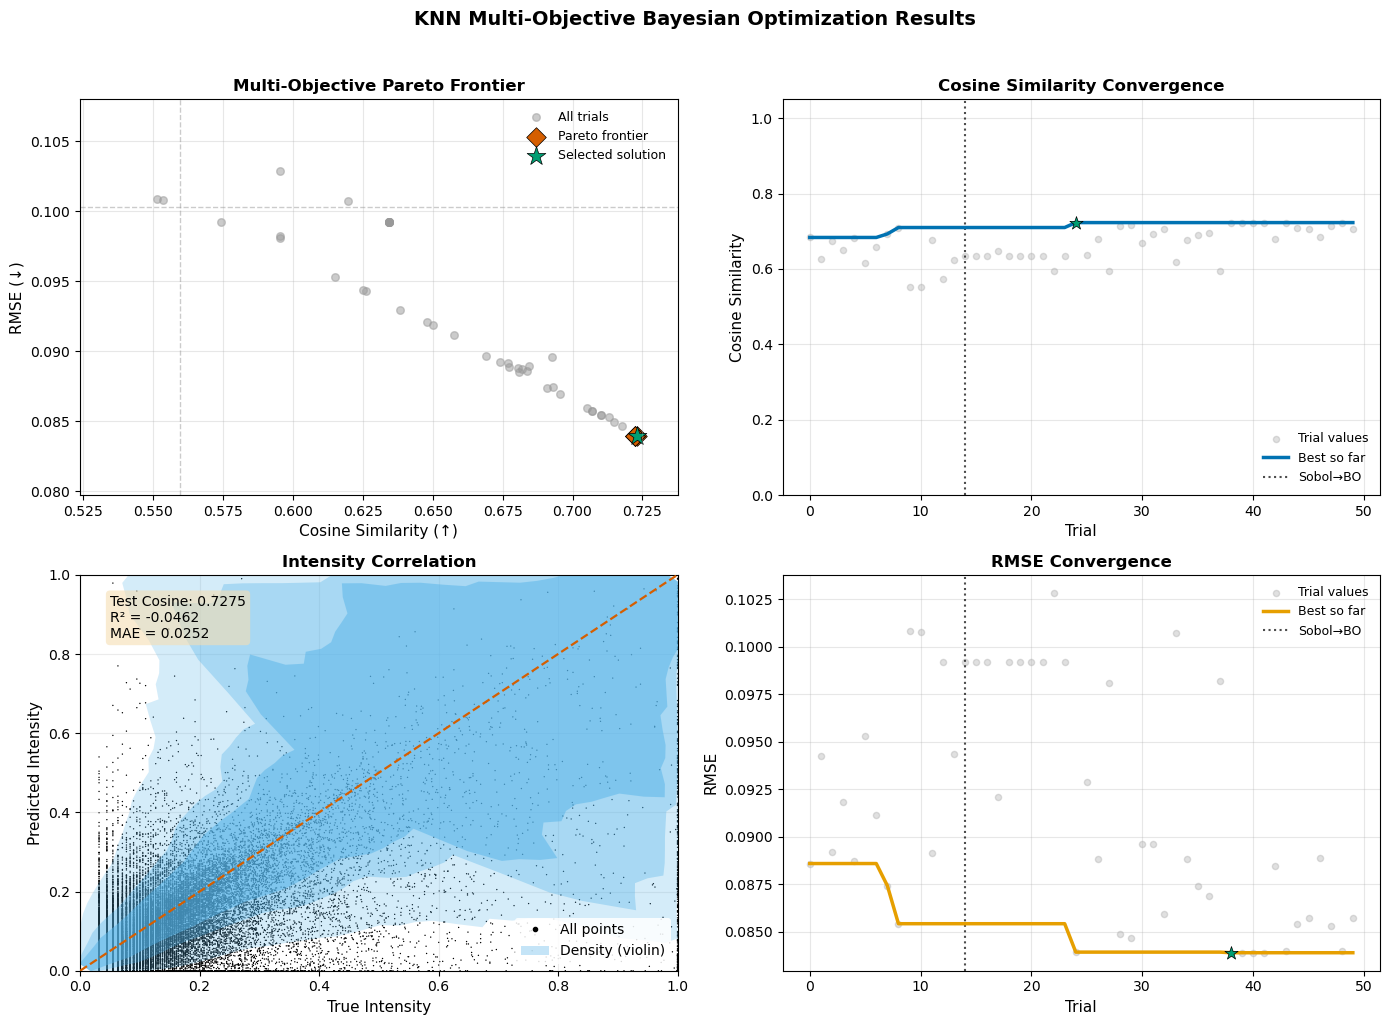

In [14]:
# ============================================================================
# OPTIMIZATION RESULTS VISUALIZATION - STANDARD 2x2 SUITE
# ============================================================================

# Colorblind-friendly Okabe–Ito palette (from standard plots)
PALETTE = {
    "blue": "#0072B2",
    "sky": "#56B4E9",
    "orange": "#E69F00",
    "vermillion": "#D55E00",
    "yellow": "#F0E442",
    "green": "#009E73",
    "purple": "#CC79A7",
    "black": "#000000",
    "grey": "#999999",
}

# Set white background style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ---------- Top-Left: Pareto Frontier ----------
ax = axes[0, 0]
ax.scatter(df_trials['cosine_similarity'], df_trials['rmse'], 
          alpha=0.5, color=PALETTE["grey"], s=30, label='All trials')
if len(pareto_trials) > 0:
    ax.scatter(pareto_trials['cosine_similarity'], pareto_trials['rmse'], 
              color=PALETTE["vermillion"], s=100, marker='D', 
              edgecolor=PALETTE["black"], linewidth=0.5, label='Pareto frontier')
ax.scatter(best_trial['cosine_similarity'], best_trial['rmse'], 
          color=PALETTE["green"], s=200, marker='*', 
          edgecolor=PALETTE["black"], linewidth=0.5, label='Selected solution')
ax.axvline(cos_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(rmse_threshold, color=PALETTE["grey"], linestyle='--', alpha=0.5, linewidth=1)
ax.set_xlabel('Cosine Similarity (↑)', fontsize=11)
ax.set_ylabel('RMSE (↓)', fontsize=11)
ax.set_title('Multi-Objective Pareto Frontier', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='best')
ax.grid(True, alpha=0.3)
ax.set_xlim([df_trials['cosine_similarity'].min() * 0.95, 
             df_trials['cosine_similarity'].max() * 1.02])
ax.set_ylim([df_trials['rmse'].min() * 0.95, 
             df_trials['rmse'].max() * 1.05])

# ---------- Top-Right: Cosine Similarity Convergence ----------
ax = axes[0, 1]
cosine_history = df_trials['cosine_similarity'].values
best_cosine_history = np.maximum.accumulate(cosine_history)

# Plot trial values as scatter
ax.scatter(range(len(cosine_history)), cosine_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_cosine_history, color=PALETTE["blue"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition from Sobol to BO
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmax(cosine_history)
ax.scatter(best_idx, cosine_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('Cosine Similarity', fontsize=11)
ax.set_title('Cosine Similarity Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='lower right')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1.05])

# ---------- Bottom-Left: Intensity Correlation (Standard Style) ----------
ax = axes[1, 0]

# Prepare data for intensity correlation plot
y_true_flat = np.ravel(data['y_test']).astype(float)
y_pred_flat = np.ravel(y_test_pred).astype(float)
m = np.isfinite(y_true_flat) & np.isfinite(y_pred_flat)
x = y_true_flat[m]
y = y_pred_flat[m]

# Rotate to (u,v) coordinates for violin visualization
root2 = np.sqrt(2.0)
u = (x + y) / root2
v = (y - x) / root2

# Bin along diagonal and compute quantiles
n_bins = 60
u_edges = np.linspace(u.min(), u.max(), n_bins + 1)
u_centers = 0.5 * (u_edges[:-1] + u_edges[1:])
widths_90 = np.full(n_bins, np.nan)
widths_75 = np.full(n_bins, np.nan)
widths_60 = np.full(n_bins, np.nan)
min_count = 10

for i in range(n_bins):
    mask = (u >= u_edges[i]) & (u < u_edges[i+1])
    if np.count_nonzero(mask) >= min_count:
        abs_v = np.abs(v[mask])
        widths_60[i] = np.percentile(abs_v, 60)
        widths_75[i] = np.percentile(abs_v, 75)
        widths_90[i] = np.percentile(abs_v, 90)

# Interpolate and smooth
def _interp_nan(a):
    xidx = np.arange(a.size)
    msk = ~np.isnan(a)
    if msk.sum() < 2:
        return np.nan_to_num(a, nan=0.0)
    return np.interp(xidx, xidx[msk], a[msk])

def _smooth(a, k=5):
    if k <= 1: return a
    kernel = np.ones(k) / k
    return np.convolve(a, kernel, mode='same')

widths_60 = _smooth(_interp_nan(widths_60), 5)
widths_75 = _smooth(_interp_nan(widths_75), 5)
widths_90 = _smooth(_interp_nan(widths_90), 5)

def band_polygon(u_vals, w_vals):
    x_upper = (u_vals - w_vals) / root2
    y_upper = (u_vals + w_vals) / root2
    x_lower = (u_vals + w_vals) / root2
    y_lower = (u_vals - w_vals) / root2
    x_poly = np.r_[x_upper, x_lower[::-1]]
    y_poly = np.r_[y_upper, y_lower[::-1]]
    return x_poly, y_poly

# Scatter points
ax.scatter(x, y, s=4, marker='.', color=PALETTE["black"],
           edgecolors='none', alpha=1.0, zorder=0, rasterized=True)

# Draw violin bands
for w, a in [(widths_90, 0.25), (widths_75, 0.35), (widths_60, 0.5)]:
    xp, yp = band_polygon(u_centers, w)
    ax.fill(xp, yp, color=PALETTE["sky"], alpha=a, edgecolor='none', zorder=2)

# Perfect prediction line
max_val = 1.0  # Clip to 1 as standard
ax.plot([0, max_val], [0, max_val], color=PALETTE["vermillion"],
        linestyle='--', linewidth=1.6, label='Perfect Prediction', zorder=4)

ax.set_xlim(0, max_val)
ax.set_ylim(0, max_val)
ax.set_xlabel('True Intensity', fontsize=11)
ax.set_ylabel('Predicted Intensity', fontsize=11)
ax.set_title('Intensity Correlation', fontsize=12, fontweight='bold')

# Legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
violin_handle = Patch(facecolor=PALETTE["sky"], alpha=0.35, edgecolor='none', label='Density (violin)')
points_handle = Line2D([0], [0], linestyle='none', marker='.', markersize=6,
                       color=PALETTE["black"], label='All points')
ax.legend(handles=[points_handle, violin_handle], loc='lower right',
          frameon=True, facecolor='white', framealpha=0.85, edgecolor='none')
ax.grid(alpha=0.25)

# Metrics annotation
test_cosine = test_metrics['cosine_similarity']
test_r2 = test_metrics['r2']
test_mae = test_metrics['mae']
text = f"Test Cosine: {test_cosine:.4f}\nR² = {test_r2:.4f}\nMAE = {test_mae:.4f}"
ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=10,
        va='top', bbox=dict(boxstyle='round', facecolor='wheat',
        alpha=0.6, edgecolor='none'), zorder=5)

# ---------- Bottom-Right: RMSE Convergence ----------
ax = axes[1, 1]
rmse_history = df_trials['rmse'].values
best_rmse_history = np.minimum.accumulate(rmse_history)

# Plot trial values as scatter
ax.scatter(range(len(rmse_history)), rmse_history, 
          alpha=0.3, s=20, color=PALETTE["grey"], label='Trial values')
# Plot best so far as line
ax.plot(best_rmse_history, color=PALETTE["orange"], linewidth=2.5, 
        label='Best so far', zorder=5)
# Mark transition
ax.axvline(config.n_initial_points, color=PALETTE["black"], 
          linestyle=':', linewidth=1.5, alpha=0.7, label='Sobol→BO')
# Highlight best point
best_idx = np.argmin(rmse_history)
ax.scatter(best_idx, rmse_history[best_idx], color=PALETTE["green"], 
          s=100, marker='*', zorder=10, edgecolor=PALETTE["black"], linewidth=0.5)

ax.set_xlabel('Trial', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('RMSE Convergence', fontsize=12, fontweight='bold')
ax.legend(frameon=False, fontsize=9, loc='upper right')
ax.grid(True, alpha=0.3)

# Overall title
plt.suptitle('KNN Multi-Objective Bayesian Optimization Results', 
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig(config.models_dir / 'knn_optimization_results.png', 
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 15. Save Results

Save the optimized model and results for future use.

In [15]:
# Prepare results dictionary
optimization_results = {
    'best_parameters': best_params,
    'best_validation_metrics': {
        'cosine_similarity': best_trial['cosine_similarity'],
        'rmse': best_trial['rmse']
    },
    'test_metrics': test_metrics,
    'pareto_frontier': pareto_trials.to_dict('records') if len(pareto_trials) > 0 else [],
    'all_trials': df_trials.to_dict('records'),
    'optimization_time': optimization_time,
    'training_time': train_time,
    'objective_thresholds': {
        'cosine_similarity': cos_threshold,
        'rmse': rmse_threshold
    },
    'config': vars(config)
}

# Save model and results
model_path = config.models_dir / 'optimized_knn_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump({
        'model': final_knn,
        'scaler': data['final_scaler'],
        'parameters': best_params
    }, f)
logger.info(f"Model saved to {model_path}")

# Save optimization results
results_path = config.models_dir / 'optimization_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(optimization_results, f)
logger.info(f"Results saved to {results_path}")

# Save results as JSON for portability
json_path = config.models_dir / 'optimization_results.json'
with open(json_path, 'w') as f:
    json.dump(optimization_results, f, indent=2, default=str)
logger.info(f"Results saved to {json_path}")

# Generate summary report
report_path = config.models_dir / 'optimization_report.txt'
with open(report_path, 'w') as f:
    f.write("MULTI-OBJECTIVE BAYESIAN OPTIMIZATION REPORT - KNN\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("OPTIMIZATION CONFIGURATION\n")
    f.write("-" * 30 + "\n")
    f.write(f"Total trials: {config.n_iterations}\n")
    f.write(f"Initial points (Sobol): {config.n_initial_points}\n")
    f.write(f"Batch size: {config.batch_size}\n")
    f.write(f"Parallel workers: {min(config.batch_size, os.cpu_count())}\n")
    f.write(f"Subsample fraction: {config.row_subsample_frac}\n")
    f.write(f"Max bins for eval: {config.max_bins_eval}\n")
    f.write(f"Optimization time: {optimization_time:.1f}s\n\n")
    
    f.write("OBJECTIVE THRESHOLDS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Cosine similarity >= {cos_threshold:.4f}\n")
    f.write(f"RMSE <= {rmse_threshold:.4f}\n\n")
    
    f.write("BEST HYPERPARAMETERS\n")
    f.write("-" * 30 + "\n")
    for param, value in best_params.items():
        f.write(f"{param:<25}: {value}\n")
    if algorithm != best_params['algorithm']:
        f.write(f"{'actual_algorithm':<25}: {algorithm}\n")
    
    f.write("\nPERFORMANCE METRICS\n")
    f.write("-" * 30 + "\n")
    f.write(f"Validation Cosine (subsample): {best_trial['cosine_similarity']:.6f}\n")
    f.write(f"Validation RMSE (subsample): {best_trial['rmse']:.6f}\n")
    f.write(f"Validation Cosine (full): {full_eval['cosine_similarity'][0]:.6f}\n")
    f.write(f"Validation RMSE (full): {full_eval['rmse'][0]:.6f}\n")
    f.write(f"Test Cosine: {test_metrics['cosine_similarity']:.6f}\n")
    f.write(f"Test RMSE: {test_metrics['rmse']:.6f}\n")
    f.write(f"Test MAE: {test_metrics['mae']:.6f}\n")
    f.write(f"Test R²: {test_metrics['r2']:.6f}\n")
    
    f.write("\nPARETO FRONTIER\n")
    f.write("-" * 30 + "\n")
    f.write(f"Number of Pareto-optimal solutions: {len(pareto_trials)}\n")
    if len(pareto_trials) > 0:
        f.write(f"Cosine range: [{pareto_trials['cosine_similarity'].min():.4f}, "
               f"{pareto_trials['cosine_similarity'].max():.4f}]\n")
        f.write(f"RMSE range: [{pareto_trials['rmse'].min():.4f}, "
               f"{pareto_trials['rmse'].max():.4f}]\n")

logger.info(f"Report saved to {report_path}")

print("\n" + "=" * 60)
print("OPTIMIZATION COMPLETE")
print("=" * 60)
print(f"Optimization time: {optimization_time:.1f}s ({optimization_time/60:.1f} minutes)")
print(f"Training time: {train_time:.1f}s")
print(f"\nBest validation performance:")
print(f"  Cosine Similarity: {best_trial['cosine_similarity']:.6f}")
print(f"  RMSE: {best_trial['rmse']:.6f}")
print(f"\nTest set performance:")
print(f"  Cosine Similarity: {test_metrics['cosine_similarity']:.6f}")
print(f"  RMSE: {test_metrics['rmse']:.6f}")
print(f"\nPareto frontier contains {len(pareto_trials)} solutions")
print(f"All results saved to {config.models_dir}")

2025-08-25 16:54:16,136 - INFO - Model saved to ../models/knn_bayesian_optimized/optimized_knn_model.pkl
2025-08-25 16:54:16,142 - INFO - Results saved to ../models/knn_bayesian_optimized/optimization_results.pkl
2025-08-25 16:54:16,147 - INFO - Results saved to ../models/knn_bayesian_optimized/optimization_results.json
2025-08-25 16:54:16,151 - INFO - Report saved to ../models/knn_bayesian_optimized/optimization_report.txt



OPTIMIZATION COMPLETE
Optimization time: 306.0s (5.1 minutes)
Training time: 0.0s

Best validation performance:
  Cosine Similarity: 0.723083
  RMSE: 0.083928

Test set performance:
  Cosine Similarity: 0.727541
  RMSE: 0.072062

Pareto frontier contains 5 solutions
All results saved to ../models/knn_bayesian_optimized
